In [72]:
random_state = 42

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [73]:
train = pd.read_csv("../data/pre_train.csv")
test = pd.read_csv("../data/pre_test.csv")
y = pd.read_csv("../data/target.csv")

In [74]:
scaler = StandardScaler()

train[train.columns] = scaler.fit_transform(train)
test[test.columns] = scaler.transform(test)

In [75]:
y = y.values.ravel()

# train_test_split

In [76]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

In [77]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(893296, 88) (893296,) (223325, 88) (223325,)


# 분석

## RandomForest

In [78]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=10, criterion='squared_error', random_state=random_state, n_jobs=-1)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [79]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE train: {np.sqrt(metrics.mean_squared_error(y_train, pred_train))}')
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_test, pred_test))}')

RMSE train: 3146.8184736744815
RMSE test: 7317.405236034042


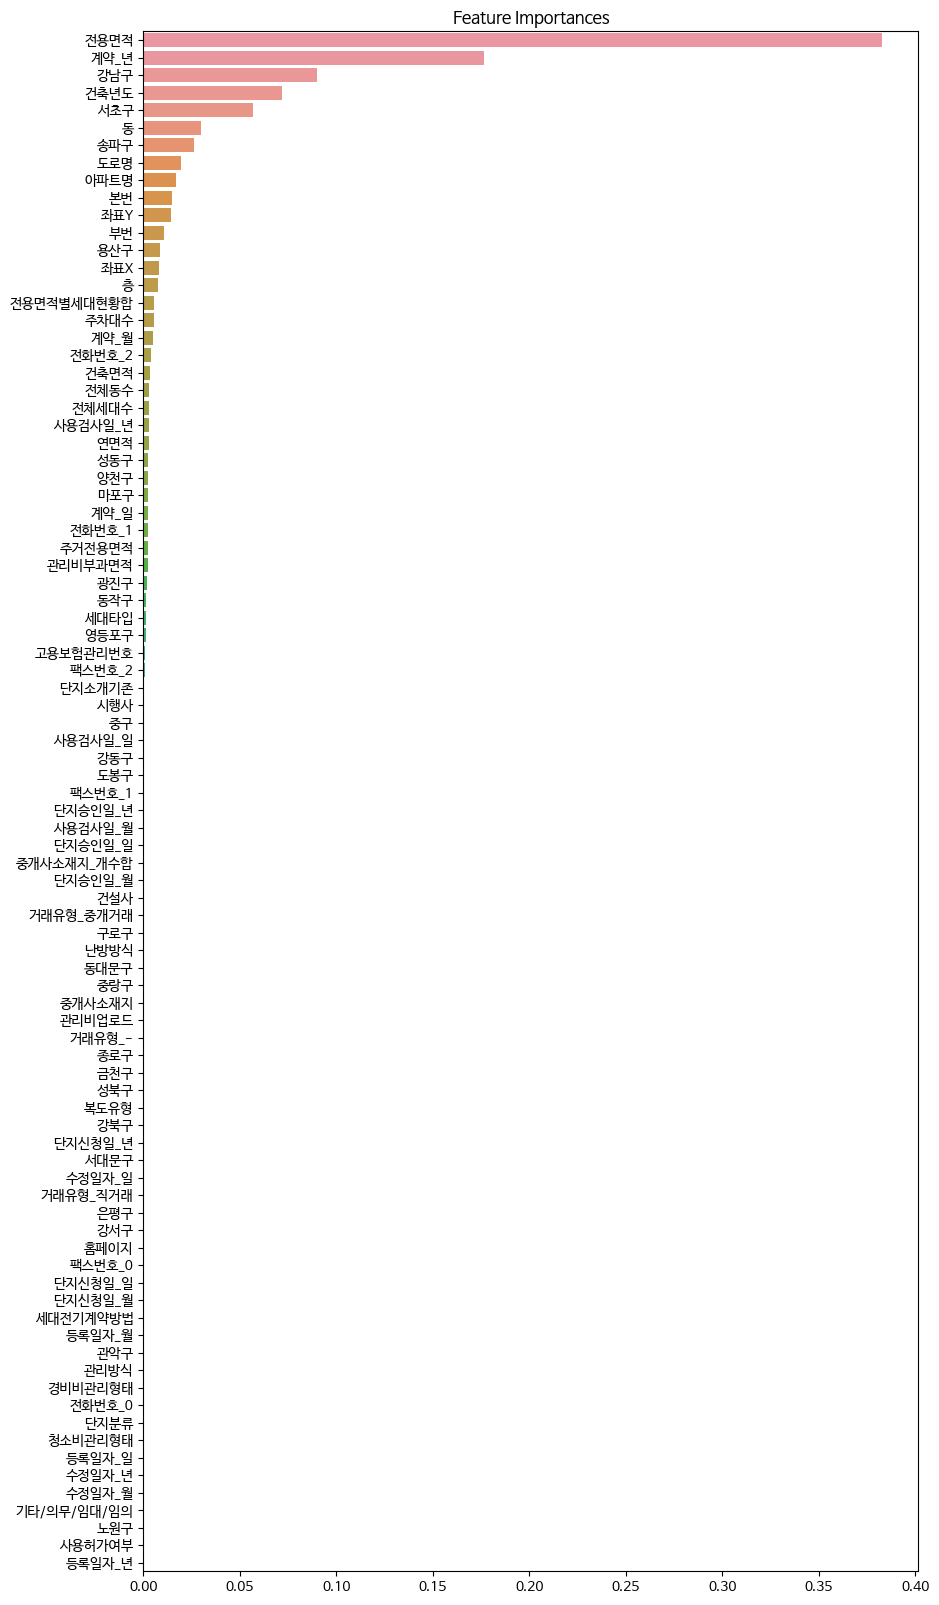

In [80]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(x_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,20))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [81]:
import lightgbm as lgb

model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

In [82]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# 파라미터 설정
params = {
    'objective': 'reg:squarederror',  # 회귀 문제로 설정
    'eval_metric': 'rmse',            # RMSE를 평가 지표로 설정
    'max_depth': 6,                   # 트리 깊이 설정
    'learning_rate': 0.1,             # 학습률 설정
    'subsample': 0.8,                 # 샘플링 비율
    'colsample_bytree': 0.8           # 각 트리에서 사용하는 특성 비율
}

# 평가할 데이터셋 설정
evals = [(dtrain, 'train'), (dtest, 'eval')]

# 모델 학습 (train() 함수 사용)
model = xgb.train(params=params, 
                  dtrain=dtrain, 
                  num_boost_round=10000,    # 최대 부스팅 라운드
                  evals=evals,              # 검증 데이터셋
                  early_stopping_rounds=100,  # 성능 향상이 없으면 100 라운드 후 종료
                  verbose_eval=True)         # 학습과정을 출력

# 예측
y_pred = model.predict(dtest)

[0]	train-rmse:43419.44785	eval-rmse:43323.13453
[1]	train-rmse:40604.18534	eval-rmse:40539.91328
[2]	train-rmse:38599.74482	eval-rmse:38554.89407
[3]	train-rmse:37217.83799	eval-rmse:37169.14894
[4]	train-rmse:35440.80563	eval-rmse:35394.47351
[5]	train-rmse:33453.03606	eval-rmse:33426.72080
[6]	train-rmse:31683.74000	eval-rmse:31666.71158
[7]	train-rmse:30107.88381	eval-rmse:30106.14541
[8]	train-rmse:28745.76995	eval-rmse:28757.90343
[9]	train-rmse:27551.83232	eval-rmse:27568.89465
[10]	train-rmse:26450.06947	eval-rmse:26479.69899
[11]	train-rmse:25654.48493	eval-rmse:25691.20047
[12]	train-rmse:24944.74915	eval-rmse:24981.96495
[13]	train-rmse:24006.94419	eval-rmse:24048.71085
[14]	train-rmse:23164.93400	eval-rmse:23218.77621
[15]	train-rmse:22573.81713	eval-rmse:22628.91019
[16]	train-rmse:21964.87529	eval-rmse:22022.40592
[17]	train-rmse:21421.21402	eval-rmse:21482.31739
[18]	train-rmse:20839.94040	eval-rmse:20912.69083
[19]	train-rmse:20322.97140	eval-rmse:20404.22828
[20]	train

In [83]:
import pickle

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model/saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [84]:
real_test = xgb.DMatrix(test)

In [85]:
real_test_pred = model.predict(real_test)

In [86]:
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])

In [87]:
preds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  9272 non-null   int64
dtypes: int64(1)
memory usage: 72.6 KB


In [88]:
preds_df.to_csv('../data/sub/output_xgboost_001.csv', index=False)